# Models


## Installs


In [ ]:
pip install ultralytics

In [ ]:
pip install torchinfo


In [ ]:
import os
import cv2
import numpy as np


def get_yolo_preds():
    """
    Run YOLO predictions, save cropped persons, and save the whole image with bounding boxes.

    Args:
        net: YOLO model loaded with cv2.dnn.readNetFromDarknet.
        input_img_path (str): Path to the input image.
        output_img_path (str): Path to save the output image with bounding boxes.
        confidence_threshold (float): Minimum confidence for predictions.
        overlapping_threshold (float): Threshold for non-maxima suppression.
        labels (list): List of class labels.
        show_display (bool): Whether to display the image with bounding boxes.
    """
            # Load COCO labels
    labels_path = "./DARKNET/coco.txt"
    try:
        with open(labels_path, "r", encoding="utf-8") as f:
            labels = f.read().strip().split("\n")
    except FileNotFoundError:
        print(f"Error: {labels_path} not found. Please check the file path.")
        exit()

    # Define YOLO paths and parameters
    yolo_cfg = "./DARKNET/model_data/yolov3.cfg"
    yolo_weights = "./DARKNET/model_data/yolov3.weights"
    input_img_path = "./DARKNET/test3.jpg"
    output_img_path = "./DARKNET/output"
    confidence_threshold = 0.5
    overlapping_threshold = 0.5

    # Initialize YOLO model
    net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
    # if cuda: 
    #     net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    #     net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # Ensure output directory exists if the output_img_path is provided
    if output_img_path:
        output_dir = os.path.dirname(output_img_path)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    # Generate random colors for each class
    np.random.seed(123)
    colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

    # Get the output layer names of the YOLO network
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    (H, W) = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Initialize lists for detections
    boxes, confidences, classIDs = [], [], []

    # Loop through each output layer
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Only keep detections for "person" (class ID 0)
            if confidence > confidence_threshold and classID == 0:
                # Scale bounding boxes back to image dimensions
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Perform non-maxima suppression to reduce overlapping boxes
    bboxes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, overlapping_threshold)
    image2 = image.copy()
    # Collect cropped persons and draw bounding boxes on the image
    cropped_persons = []
    if len(bboxes) > 0:
        for i in bboxes.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # Draw bounding box on the original image
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = f"{labels[classIDs[i]]}: {confidences[i]:.2f}"
            cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Crop the person from the image (no bounding box)
            cropped_person = image2[y:y + h, x:x + w]
            cropped_persons.append(cropped_person)

            # Save the cropped person image
            cropped_filename = f"./DARKNET/output/person_{i + 1}_confidence_{confidences[i]:.2f}.jpg"
            cv2.imwrite(cropped_filename, cropped_person)
            print(f"Cropped Person Saved: {cropped_filename}")

    # Save the full image with bounding boxes
    if output_img_path:
        if not output_img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            output_img_path += '.jpg'  # Add .jpg extension if none is provided
        if cv2.imwrite(output_img_path, image):
            print(f"Image with bounding boxes saved to {output_img_path}")
        else:
            print("Failed to save the image with bounding boxes.")





# Run YOLO predictions
if __name__ == '__main__':
    get_yolo_preds()



In [ ]:
import torch
# Example tensor
tensor = torch.randn(3, 3)

# Check the device
print("Tensor is on:", tensor.device)
# Example model
from torchvision import models

model = models.inception_v3(weights=None)

# Check the device of the model
print("Model is on:", next(model.parameters()).device)

# Move tensor to GPU
if torch.cuda.is_available():
    tensor = tensor.to('cuda')  # or tensor.cuda()
    print("Tensor moved to GPU:", tensor.device)
else:
    tensor = tensor.to('cpu')  # or tensor.cpu()
    print("Tensor moved to CPU:", tensor.device)
    # Move model to GPU
if torch.cuda.is_available():
    model = model.to('cuda')
    print("Model moved to GPU.")
else:
    model = model.to('cpu')
    print("Model moved to CPU.")
    
    
    
import torch
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")


# Resnet50xInceptionv3 Training


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:

from torchvision import models, transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import inception_v3, Inception_V3_Weights

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import os

# Dataset path
# dataset_path = r"D:\\THESIS PROJECT FOLDER\\test"
dataset_path = "./cropped_images"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

# Image transformations for ResNet50 and InceptionV3
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset using torchvision
dataset = datasets.ImageFolder(dataset_path, transform=None)
class_names = dataset.classes
print(class_names)
num_classes = len(class_names)

# Split dataset
train_data, val_data = train_test_split(dataset, test_size=0.2, stratify=dataset.targets)

# Apply transformations for each model
train_loader_resnet = DataLoader(
    datasets.ImageFolder(dataset_path, transform=transform_resnet), batch_size=32, shuffle=True
)
train_loader_inception = DataLoader(
    datasets.ImageFolder(dataset_path, transform=transform_inception), batch_size=32, shuffle=True
)


# For ResNet50, retain the model's structure and extract features dynamically
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Keep layers up to the last conv layer

    def forward(self, x):
        x = self.features(x)  # Extract features
        return x





# Initialize feature extractors
base_model_resnet = ResNet50FeatureExtractor(models.resnet50(weights=ResNet50_Weights.DEFAULT))

# Freeze layers
for param in base_model_resnet.parameters():
    param.requires_grad = False

for param in list(base_model_resnet.parameters())[-94:]:
    param.requires_grad = True


def extract_features_fixed(model, dataloader, device):
    model = model.to(device)
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            print("Input to model:", images.shape)  # Shape of input image batch
            feature_maps = model(images)
            print("Output of model:", feature_maps.shape)  # Shape of feature maps
            features.append(feature_maps.cpu().numpy())
            labels.extend(targets.numpy())
    features = np.concatenate(features, axis=0)
    return features, np.array(labels)


# Extract features
print("Extracting features from ResNet50...")
features_resnet, labels_resnet = extract_features_fixed(base_model_resnet, train_loader_resnet, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print("ResNet50 Feature Map Shape:", features_resnet.shape)



In [ ]:
class InceptionV3FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(InceptionV3FeatureExtractor, self).__init__()
        # Remove the FC layer and include everything else
        self.features = nn.Sequential(
            *list(original_model.children())[:-3]  # Remove the FC layer
        )

    def forward(self, x):
        x = self.features(x)
        return x

base_model = models.inception_v3(aux_logits=False)
# Load pretrained weights while ignoring unexpected keys
pretrained_model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

# # Compare weights of the first convolutional layer
state_dict = pretrained_model.state_dict()

base_model.load_state_dict(state_dict, strict=False)  # Ignore unexpected keys

first_conv_weights = base_model.Conv2d_1a_3x3.conv.weight.data
print("Mean of Conv2d_1a_3x3 weights:", first_conv_weights.mean().item())
print("Std of Conv2d_1a_3x3 weights:", first_conv_weights.std().item())
# is_pretrained = torch.allclose(
#     base_model.Conv2d_1a_3x3.conv.weight.data,
#     pretrained_model.Conv2d_1a_3x3.conv.weight.data
# )
# print("Is the model pre-trained?", is_pretrained)
# Pass the modified model to your custom feature extractor
base_model_inception = InceptionV3FeatureExtractor(base_model)

for param in base_model_inception.parameters():
    param.requires_grad = False
# Unfreeze some layers for fine-tuning

for param in list(base_model_inception.parameters())[-50:]:
    param.requires_grad = True
    


In [ ]:
from torchinfo import summary
from torchvision.models import inception_v3



# Define the input size (batch size, channels, height, width)
input_size = (32, 3, 299, 299)  # Example for InceptionV3

# Print the summary
# summary(base_model_inception, input_size=input_size)
# Print the full model without truncation
torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(base_model_inception)

In [ ]:
import torch

# Example input: batch size of 1, 3 color channels, 299x299 image
example_input = torch.randn(32, 3, 299, 299)

# Extract features
base_model_inception.eval()  # Ensure evaluation mode
with torch.no_grad():
    features = base_model_inception(example_input)
    print("Feature shape:", features.shape)


In [ ]:

# Correct feature extraction for InceptionV3
print("Extracting features from InceptionV3...")
features_inception, _ = extract_features_fixed(
    base_model_inception,
    train_loader_inception,
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
print("InceptionV3 Feature Map Shape:", features_inception.shape)

In [ ]:

# Apply Global Average Pooling
features_resnet_gap = features_resnet.mean(axis=(2, 3))  # GAP for ResNet
features_inception_gap = features_inception.mean(axis=(2, 3))  # GAP for Inception

# Concatenate feature maps
fused_features = np.concatenate([features_resnet_gap, features_inception_gap], axis=1)
print("Fused Feature Shape:", fused_features.shape)

# Define the classifier
class ClassifierModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassifierModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return self.sigmoid(x)

input_dim = fused_features.shape[1]
model = ClassifierModel(input_dim)

# Compile the model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model defined and ready for training.")

In [ ]:
from torch.utils.data import TensorDataset


fused_features_tensor = torch.tensor(fused_features, dtype=torch.float32)
labels1_tensor = torch.tensor(labels_resnet, dtype=torch.float32)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(fused_features_tensor, labels1_tensor, test_size=0.2, random_state=42)
print("Training the classifier after unfreezing some layers...")

# Convert the data to DataLoader for batch processing
train_dataset = TensorDataset(X_train1, y_train1)
test_dataset = TensorDataset(X_test1, y_test1)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)


# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the model weights
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluating the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()  # Get model predictions
        y_pred.extend((outputs > 0.5).int().numpy())  # Convert probabilities to binary predictions
        y_true.extend(labels.int().numpy())

# Print classification report and accuracy score
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Accuracy Score:", accuracy_score(y_true, y_pred))

# Save the model (optional)
# model_save_path = 'saved_model.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

##WHOLE MODEL RESNETXINCEPTION

In [27]:
import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns

# Dataset path
dataset_path = "./augTEST"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

# Define transformations
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_resnet = ImageFolder(dataset_path, transform=transform_resnet)
dataset_inception = ImageFolder(dataset_path, transform=transform_inception)

class_names = dataset_resnet.classes
num_classes = len(class_names)
# Train-test split
train_idx, val_idx = train_test_split(list(range(len(dataset_resnet))), test_size=0.2, random_state=42)

train_resnet = torch.utils.data.Subset(dataset_resnet, train_idx)
val_resnet = torch.utils.data.Subset(dataset_resnet, val_idx)

train_inception = torch.utils.data.Subset(dataset_inception, train_idx)
val_inception = torch.utils.data.Subset(dataset_inception, val_idx)

train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
val_loader_resnet = DataLoader(val_resnet, batch_size=32, shuffle=False)

train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)
val_loader_inception = DataLoader(val_inception, batch_size=32, shuffle=False)

# Define the model
class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super(FusionModel, self).__init__()
        
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.inception = models.inception_v3(aux_logits=False)
        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        state_dict = pretrained_model.state_dict()
        self.inception.load_state_dict(state_dict, strict=False)
        
        # Step 1: Freeze All Layers Initially**
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.inception.parameters():
            param.requires_grad = False  
        
        # for param in self.resnet.fc.parameters():
        #       param.requires_grad = True
        # for param in self.inception.fc.parameters():
        #       param.requires_grad = True    
              
        self.resnet.fc = nn.Identity()
        self.inception.fc = nn.Identity()
        
        self.batch_norm = nn.BatchNorm1d(4096)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.55)
        self.fc = nn.Linear(4096, 1)
        
    def forward(self, x_resnet, x_inception):
        resnet_features = self.resnet(x_resnet)
        inception_features = self.inception(x_inception)
        if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
            inception_features = inception_features[0]  # Take only the main output
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
        fused_features = self.batch_norm(fused_features)
        fused_features = self.relu(fused_features)
        fused_features = self.dropout(fused_features)
        output = torch.sigmoid(self.fc(fused_features))
        return output

# Initialize model
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




E:\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [5]:
from torchinfo import summary
from torchvision.models import inception_v3


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


FusionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [35]:
# Training loop

def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5):
   
    
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

       
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, _ = inception_batch
            
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)


        model.train()  # Return model to training mode

    print("Training complete")
   
    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


history, metrics = train_model(model, train_loader_resnet, train_loader_inception, 
                      val_loader_resnet, val_loader_inception, 
                      criterion, optimizer, epochs=5 )


# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to("cuda"), x_inception.to("cuda"), y.to("cuda").float()
        outputs = model(x_resnet, x_inception).squeeze()
        preds = (outputs > 0.5).cpu().numpy()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred))
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")


  # Save history to CSV


Epoch 1/5:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it, accuracy=100, loss=0.407]



Epoch 1/5: Train Loss = 0.4066, Train Accuracy = 100.00%
Validation Loss = 0.5250, Validation Accuracy = 100.00%



Epoch 2/5: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it, accuracy=92, loss=0.301]



Epoch 2/5: Train Loss = 0.3008, Train Accuracy = 92.00%
Validation Loss = 0.4981, Validation Accuracy = 85.71%



Epoch 3/5: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, accuracy=100, loss=0.204]



Epoch 3/5: Train Loss = 0.2040, Train Accuracy = 100.00%
Validation Loss = 0.4746, Validation Accuracy = 85.71%



Epoch 4/5: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, accuracy=100, loss=0.201]



Epoch 4/5: Train Loss = 0.2013, Train Accuracy = 100.00%
Validation Loss = 0.4581, Validation Accuracy = 85.71%



Epoch 5/5: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it, accuracy=100, loss=0.154]



Epoch 5/5: Train Loss = 0.1545, Train Accuracy = 100.00%
Validation Loss = 0.4484, Validation Accuracy = 85.71%

Training complete

Additional Metrics:
False Positive Rate (FPR): 0.3333
False Negative Rate (FNR): 0.0000
AUC-ROC Score: 1.0000
TN: 2, FP: 1, FN: 0, TP: 4
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.80      1.00      0.89         4

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7

Accuracy Score: 0.8571428571428571


In [7]:
# Unfreeze the last 50 layers of Inception and the last 94 layers of ResNet
for param in list(model.inception.parameters())[-50:]:
    param.requires_grad = True
for param in list(model.resnet.parameters())[-94:]:
    param.requires_grad = True

 
# for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
    
# Reset optimizer with a lower learning rate
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


In [8]:
from torchinfo import summary
from torchvision.models import inception_v3


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


FusionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [9]:

# Fine-tune the model
train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception)
# **Evaluation after Fine-Tuning**
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()
        outputs = model(x_resnet, x_inception).squeeze()
        preds = (outputs > 0.5).cpu().numpy()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)

print("**Fine-Tuned Model Evaluation**")
print(classification_report(y_true, y_pred))
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

Epoch 1/5: 100%|██████████| 42/42 [00:52<00:00,  1.25s/it, accuracy=90.5, loss=0.344] 



Epoch 1/5: Train Loss = 0.2318, Train Accuracy = 90.47%
Validation Loss = 0.2295, Validation Accuracy = 91.62%



Epoch 2/5: 100%|██████████| 42/42 [00:51<00:00,  1.22s/it, accuracy=97.1, loss=0.0668]



Epoch 2/5: Train Loss = 0.0853, Train Accuracy = 97.15%
Validation Loss = 0.2236, Validation Accuracy = 93.71%



Epoch 3/5: 100%|██████████| 42/42 [00:51<00:00,  1.23s/it, accuracy=99.4, loss=0.0937] 



Epoch 3/5: Train Loss = 0.0209, Train Accuracy = 99.40%
Validation Loss = 0.2276, Validation Accuracy = 94.01%



Epoch 4/5: 100%|██████████| 42/42 [00:51<00:00,  1.22s/it, accuracy=99.5, loss=0.00181] 



Epoch 4/5: Train Loss = 0.0166, Train Accuracy = 99.55%
Validation Loss = 0.2029, Validation Accuracy = 94.31%



Epoch 5/5: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it, accuracy=99.5, loss=0.00728]



Epoch 5/5: Train Loss = 0.0156, Train Accuracy = 99.47%
Validation Loss = 0.2540, Validation Accuracy = 93.71%

Training complete
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       180
         1.0       0.92      0.94      0.93       154

    accuracy                           0.94       334
   macro avg       0.94      0.94      0.94       334
weighted avg       0.94      0.94      0.94       334

Accuracy Score: 0.937125748502994


In [12]:

# Save the PyTorch model
torch.save(model, "Saved models/resnet_inception_fullmodel_cropped.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("Saved models/resnet_inception_fullmodel_cropped.pt")

# STATE DICT SAVED, WEIGHS ONLY
# from fusion_model import FusionModel
# torch.save(model.state_dict(), 'Saved models/resnet_inception_fullmodel_cropped.pth')
# state_dict = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth', map_location=device)
# fussionmodel = FusionModel()
# fussionmodel.load_state_dict(state_dict)
# fussionmodel.to(device)
# fussionmodel.eval()

# FULL MODEL
# from fusion_model import FusionModel

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval()


In [2]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("Saved models/resnet_inception_fullmodel_cropped.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Appropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Appropriate


In [30]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
    
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

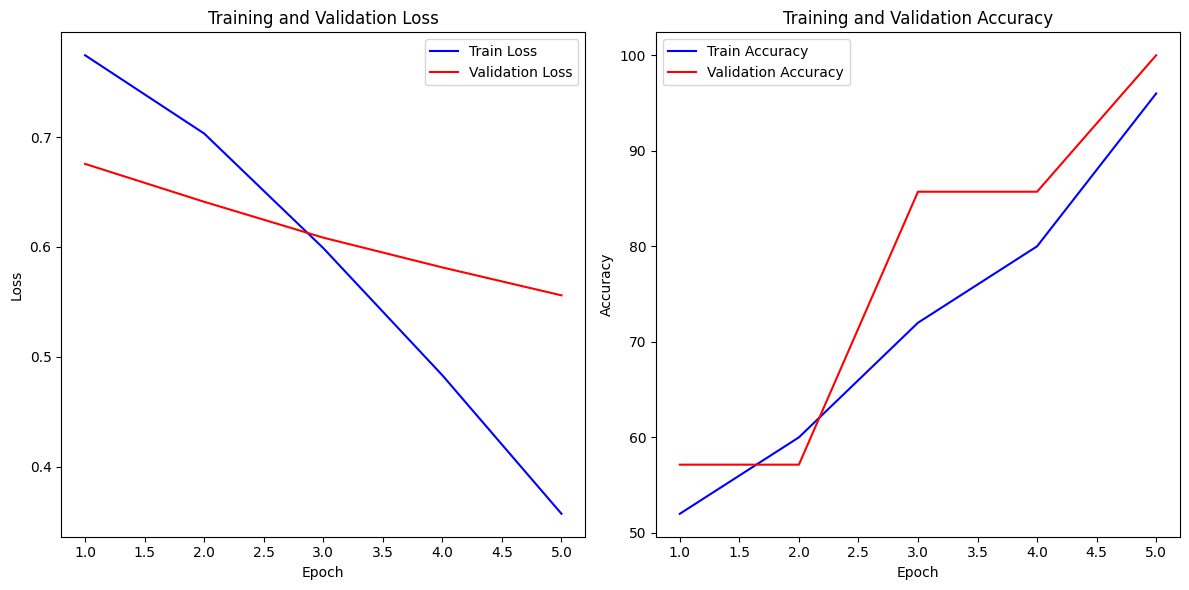

In [31]:
plot_from_history(history)

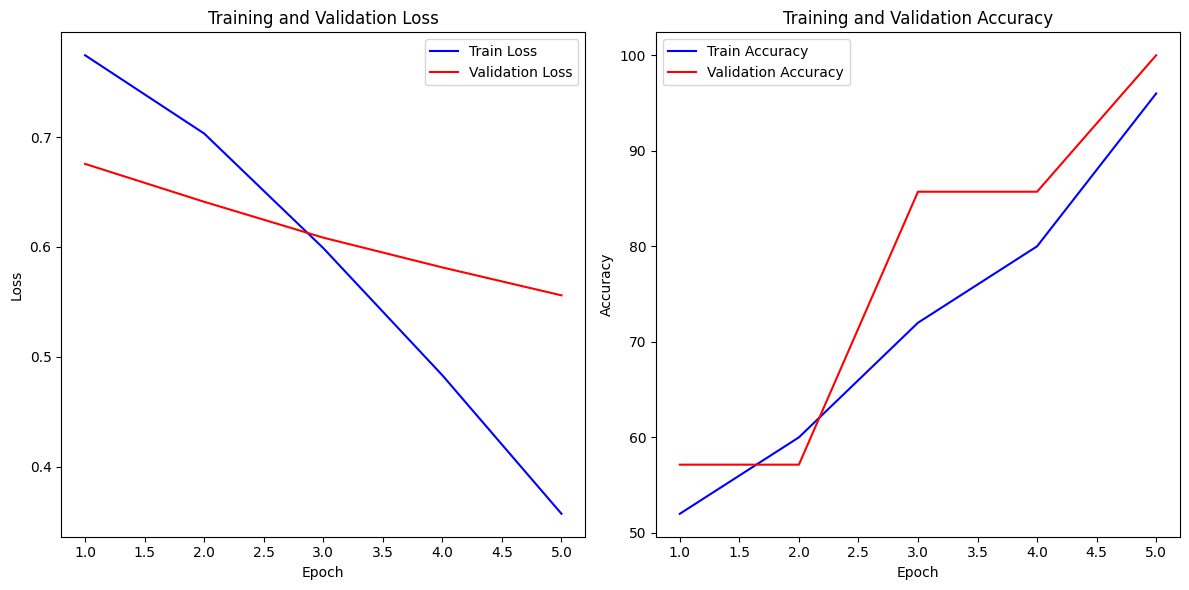

In [32]:
import pandas as pd
df = pd.DataFrame(history)

df.to_csv('Saved models/training_history2.csv', index=False)
history_df = pd.read_csv('Saved models/training_history2.csv')

history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(history)

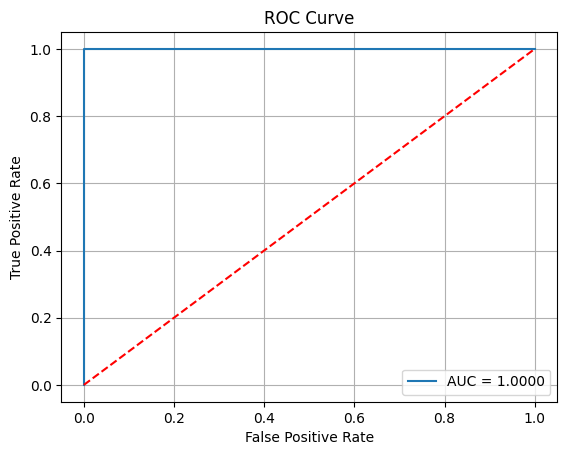

In [33]:
import pandas as pd

# Flatten data for CSV saving
metrics_flat = {
    "class_names": metrics["class_names"],
    "fpr": metrics["fpr"],
    "fnr": metrics["fnr"],
    "auc_roc": metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in metrics["confusion_matrix"]]
}
plot_roc_curve(metrics_flat)


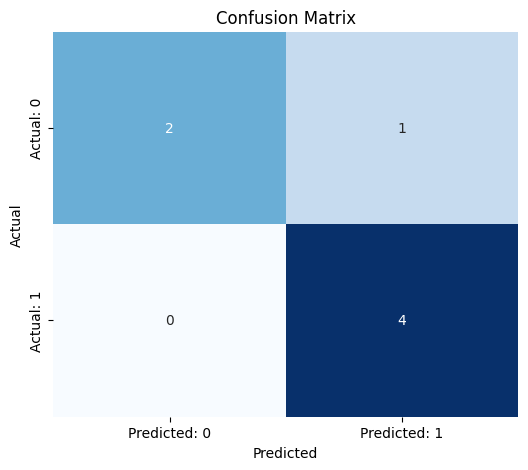

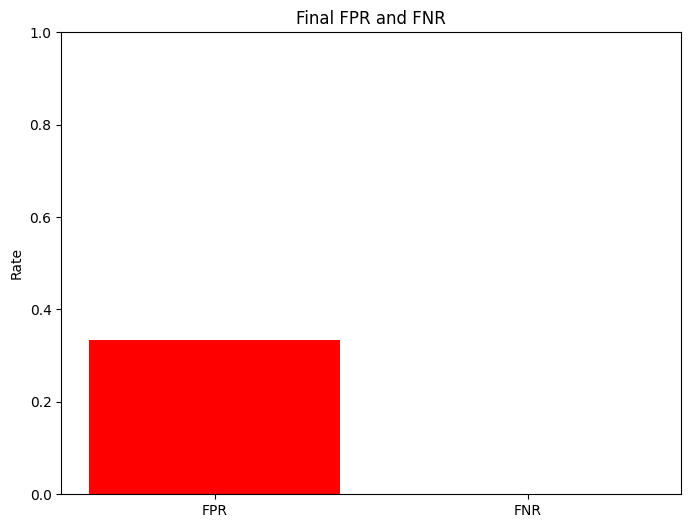

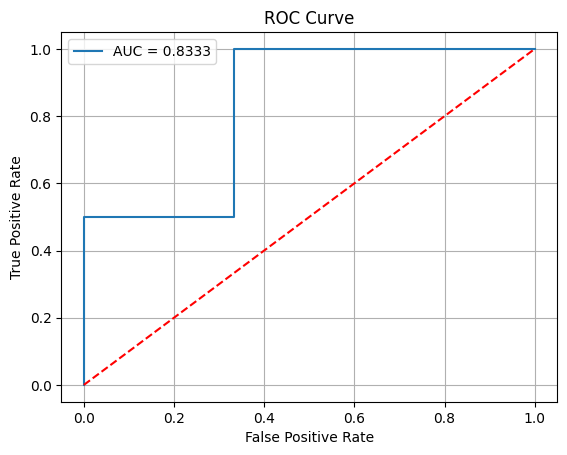

In [34]:

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_flat)
metrics_df.to_csv('Saved models/first_training_metrics.csv', index=False)


# Load the CSV file containing the final metrics
metrics_df = pd.read_csv('Saved models/metrics_for_plotting.csv')

# Extract individual metrics
auc_score = metrics_df['auc_roc'][0]
fpr = metrics_df['fpr'][0]
fnr = metrics_df['fnr'][0]

# Extract confusion matrix (flattened form)
conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
tn, fp, fn, tp = conf_matrix

# Extract ROC curve data (flattened form)
roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
# Confusion Matrix heatmap
conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot FPR and FNR
plt.figure(figsize=(8, 6))
plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
plt.ylabel('Rate')
plt.title('Final FPR and FNR')
plt.ylim(0, 1)
plt.show()
# Plot ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(roc_fpr, roc_tpr, color='darkblue', label='ROC Curve')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

plt.figure()
plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


# ResnetxSVM

In [24]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob

# Dataset path
dataset_path = "./cropped_images"

if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset and preprocess
image_paths = []
labels = []
class_names = sorted(os.listdir(dataset_path))  # Ensure consistent label ordering
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
print(class_names)
for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_path in glob.glob(f"{class_folder}/*.jpg"):
            image_paths.append(img_path)
            labels.append(class_to_idx[class_name])

print("Total images found:", len(image_paths))

# Load and preprocess images
images = []

for img_path in tqdm(image_paths, desc="Loading images"):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    images.append(img_tensor)

images = torch.stack(images)  # Shape: [num_samples, 3, 224, 224]
labels = torch.tensor(labels)

# Load ResNet50 pre-trained model (feature extractor)
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()  # Remove the classification layer
resnet.eval()  # Set to evaluation mode

for param in resnet.parameters():
    param.requires_grad = False

for param in list(resnet.parameters())[-75:]:
    param.requires_grad = True

# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
images = images.to(device)

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Keep layers up to the last conv layer

    def forward(self, x):
        x = self.features(x)  # Extract features
        return x
    
# WORKS EXACTLY THE SAME WITH NN.IDENTITY IF nn.Sequential(*list(base_model.children())[:-1]) , gap will be retained
base_model_resnet = ResNet50FeatureExtractor(models.resnet50(weights=ResNet50_Weights.DEFAULT))
base_model_resnet.eval()
base_model_resnet = base_model_resnet.to(device)

# Extract features

# torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
# print(base_model_resnet)
# torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
# print(resnet)


Directory found: ./cropped_images
Contents: ['Appropriate', 'Inappropriate']
['Appropriate', 'Inappropriate']
Total images found: 1666


Loading images: 100%|██████████| 1666/1666 [00:19<00:00, 87.66it/s] 


In [ ]:
print("Extracting features using ResNet50...")
features = []
with torch.no_grad():
    for img_tensor in tqdm(images, desc="Extracting features"):
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        # print("Input to model:", images.shape)  #
        feature = resnet(img_tensor)  # Extract features
        # print("Output of model:", feature.shape)  #
        feature = feature.squeeze().cpu().numpy() 
        # print("Output of model:", feature.shape)  #
        features.append(feature)

features = np.array(features)

In [ ]:
print("Flattened Feature Shape:", features.shape)

In [ ]:

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels.numpy(), test_size=0.2, random_state=42)

# Train SVM Classifier
print("Training SVM classifier...")
svm_classifier = svm.SVC(kernel='linear', C=1, probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM classifier
y_pred = svm_classifier.predict(X_test)
y_prob = svm_classifier.predict_proba(X_test)[:, 1]  # Now we use predict_proba()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy Score:", accuracy_score(y_test, y_pred))




In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
def fromfile_plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
def plot_feature_importance(svm_classifier, feature_names):
    if hasattr(svm_classifier, "coef_"):
        importance = np.abs(svm_classifier.coef_).flatten()
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(importance)), importance[sorted_idx], align="center")
        plt.xticks(range(len(importance)), np.array(feature_names)[sorted_idx], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importance in Linear SVM")
        plt.show()
    else:
        print("Feature importance is only available for linear SVMs.")


In [ ]:
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve
)
plot_confusion_matrix(y_test, y_pred, class_names)
# Extract TN, FP, FN, TP

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print


In [ ]:

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Compute AUC-ROC using predict_proba()
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
import pickle

metrics = {
    "class_names": class_names,
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "fpr": fpr,
    "fnr": fnr,
    "auc_roc": auc_score,
    "roc_curve": (fpr_vals, tpr_vals)  # Save ROC data for later plotting
}

# Save as a NumPy file
np.savez("svm_metrics.npz", **metrics)

# Save using Pickle (optional, for structured data)
with open("svm_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("Metrics saved successfully.")
# Load metrics from NumPy file
loaded_data = np.load("svm_metrics.npz", allow_pickle=True)

# Extract metrics
conf_matrix = loaded_data["confusion_matrix"]
accuracy = loaded_data["accuracy"]
fpr = loaded_data["fpr"]
fnr = loaded_data["fnr"]
auc_score = loaded_data["auc_roc"]
fpr_vals, tpr_vals = loaded_data["roc_curve"]


# Plot the confusion matrix
fromfile_plot_confusion_matrix(conf_matrix, class_names)
print(f"Accuracy: {accuracy:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [25]:
for name, param in resnet.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train SVM Classifier
print("Training SVM classifier...")
svm_classifier = svm.SVC(kernel='linear', C=1, probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM classifier
y_pred = svm_classifier.predict(X_test)
y_prob = svm_classifier.predict_proba(X_test)[:, 1]  # Now we use predict_proba()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

In [ ]:
# Function to predict the class of a new image
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    resnet.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        # Extract features
        feature_map = resnet(img_tensor)  
        # Apply global average pooling

        flattened_features = feature_map.squeeze().cpu().numpy().reshape(1, -1)  
    prediction = svm_classifier.predict(flattened_features)  # Predict using the trained SVM classifier
    return class_names[prediction[0]]

# Test the new image prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

In [ ]:

torch.save(resnet, "Saved models/svm/resnetextractor.pth")

import joblib

svm_save_path = 'Saved models/svm'
svm_model_path = os.path.join(svm_save_path, 'torch_svm.pkl')
joblib.dump(svm_classifier, svm_model_path)

In [1]:
import os
import joblib
import torch
from torchvision import transforms
from PIL import Image

class_names = ['Appropriate', 'Inappropriate']

# Load the ResNet feature extractor
load_ex = torch.load('Saved models/svm/resnetextractor.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_ex.to(device)
print("Feature extractor loaded.")

# Load the SVM model
svm_model_path = os.path.join('Saved models/svm', 'torch_svm.pkl')
load_svm = joblib.load(svm_model_path)
print("SVM classifier loaded.")
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0).to(device)

 
    
    return img_tensor_resnet

def predict_image(img_path):
    """
    Predict the class of an image using the saved ResNet-based feature extractor and SVM classifier.

    Args:
        img_path (str): Path to the image file.

    Returns:
        str: Predicted class name.
    """
    img = Image.open(img_path).convert("RGB")
    img_tensor = resnet_transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    load_ex.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        feature_map = load_ex(img_tensor)  
        flattened_features = feature_map.squeeze().cpu().numpy().reshape(1, -1)  
    prediction = load_svm.predict(flattened_features)  # Predict using the trained SVM classifier
    return class_names[prediction[0]]


print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

C:\Users\user\AppData\Local\Temp\ipykernel_29420\1626553149.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_ex = torch.load('Saved models/svm/resnetextractor.pth')

Feature extractor loaded.
SVM classifier loaded.
['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Appropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Inappropriate


In [ ]:
# Example: Predict the class of an uploaded image
uploaded_image_path = './DARKNET/test7.jpg'
predicted_class = predict_imageSVM(uploaded_image_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

# CREATING THE CROPPED PERSONS DATASET

In [10]:
import cv2
import torch
from ultralytics import YOLO


def get_yolo_preds_and_save_crops(net, input_img_path, cropped_folder, no_person_folder, confidence_threshold=0.6, overlapping_threshold=0.3, labels=None):
    # Ensure output directories exist
    if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)

    if not os.path.exists(no_person_folder):
        os.makedirs(no_person_folder)

    # Generate random colors for each class
    np.random.seed(123)
    colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

    # Get YOLO output layer names
    ln = net.getLayerNames()
    unconnected_out_layers = net.getUnconnectedOutLayers()
    ln = [ln[i - 1] for i in unconnected_out_layers.flatten()]

    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    (H, W) = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Initialize lists for detections
    boxes = []
    confidences = []
    classIDs = []

    # Loop through each output layer
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > confidence_threshold and classID == 0:  # Class ID 0 is "person"
                # Scale bounding boxes back to image dimensions
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Perform non-maxima suppression to reduce overlapping boxes
    bboxes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, overlapping_threshold)

    # If no persons detected, save the original image in both folders
    if len(bboxes) == 0:
        # Save the image in both the cropped folder and no_person folder
        no_person_filename = os.path.join(no_person_folder, os.path.basename(input_img_path))
        cv2.imwrite(no_person_filename, image)
        print(f"Saved image with no person detected: {no_person_filename}")

        # Save the entire image in the cropped folder as well
        cropped_filename = os.path.join(cropped_folder, f"no_person_{os.path.basename(input_img_path)}")
        cv2.imwrite(cropped_filename, image)
        print(f"Saved image with no person detected in cropped folder: {cropped_filename}")
        return  # Move on to the next image if no persons are detected

    # Collect and save cropped persons
    for i in bboxes.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # Ensure the crop is within the image bounds
        x = max(0, x)
        y = max(0, y)
        w = min(W - x, w)
        h = min(H - y, h)

        # Ensure the cropped region is valid (not empty)
        if w > 0 and h > 0:
            cropped_person = image[y:y + h, x:x + w]

            # Generate a unique filename using the original image's filename, confidence level, and person index
            original_filename = os.path.splitext(os.path.basename(input_img_path))[0]
            cropped_filename = os.path.join(cropped_folder, f"{original_filename}_person_{i + 1}_confidence_{confidences[i]:.2f}.jpg")
            cv2.imwrite(cropped_filename, cropped_person)
            print(f"Saved cropped person: {cropped_filename}")
        else:
            print(f"Warning: Empty crop for {input_img_path} at box {boxes[i]}")


def process_images_in_folder(net, input_folder, output_folder, no_person_folder, confidence_threshold=0.5, overlapping_threshold=0.3, labels=None):
    # List all images in the folder
    for label in ['Appropriate', 'Inappropriate']:  # Iterate over labeled folders
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)

        if not os.path.exists(output_label_folder):
            os.makedirs(output_label_folder)

        # Process each image in the folder
        for img_filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_filename)

            if os.path.isfile(img_path) and img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {img_path}")
                # Get YOLO predictions and save the cropped persons
                get_yolo_preds_and_save_crops(net, img_path, output_label_folder, no_person_folder, confidence_threshold, overlapping_threshold, labels)

try:
    # Read labels from coco.txt
    with open("./DARKNET/coco.txt", "r", encoding="utf-8") as f:
        labels = f.read().strip().split("\n")
except FileNotFoundError:
    print("Error: coco.txt file not found. Please check the file path.")
    exit()

# Load YOLO model
yolo_path = "./DARKNET/model_data/yolov3.cfg"
weights = "./DARKNET/model_data/yolov3.weights"
net = cv2.dnn.readNetFromDarknet(yolo_path, weights)

# Optional: Use CUDA if available
# cuda = True
# if cuda:
#     net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
#     net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
#     print("YOLO model is set to use GPU (CUDA).")
# else:
#     net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)  # Force CPU
#     net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
#     print("YOLO model is using CPU.")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)  # Force CPU
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
 # Check if the model is using CUDA

    
# Define the input folder (your dataset folder) and output folder
input_folder = "./test"  # Folder containing 'Appropriate' and 'Inappropriate'
output_folder = "./cropped_imagesv2"  # Folder to save cropped person images
no_person_folder = "./no_persons_detectedv2"  # Folder to save images with no persons detected

# Process all images in the input folder
process_images_in_folder(net, input_folder, output_folder, no_person_folder, confidence_threshold=0.5, overlapping_threshold=0.3, labels=labels)

Processing image: ./test\Appropriate\00000018.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000018_person_4_confidence_1.00.jpg
Processing image: ./test\Appropriate\00000026.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000026_person_1_confidence_1.00.jpg
Processing image: ./test\Appropriate\00000030.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000030_person_7_confidence_1.00.jpg
Processing image: ./test\Appropriate\00000074.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000074_person_3_confidence_1.00.jpg
Processing image: ./test\Appropriate\00000084.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000084_person_3_confidence_1.00.jpg
Processing image: ./test\Appropriate\00000088.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000088_person_3_confidence_1.00.jpg
Processing image: ./test\Appropriate\00000100.jpg
Saved cropped person: ./cropped_imagesv2\Appropriate\00000100_person_3_confidence_1.00.jpg
Processing im

In [23]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO

def get_yolo_preds_and_save_crops(model, input_img_path, cropped_folder, no_person_folder, confidence_threshold=0.6):
    # Ensure output directories exist
    if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)

    if not os.path.exists(no_person_folder):
        os.makedirs(no_person_folder)


    # Read the input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return

    H, W = image.shape[:2]

    # Run YOLOv3 inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)

    # Extract detected objects
    boxes = []
    confidences = []

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates

            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2 - x1, y2 - y1])  # Convert to (x, y, w, h)
                confidences.append(confidence)

    # If no person detected, save original image
    if not boxes:
        no_person_filename = os.path.join(no_person_folder, os.path.basename(input_img_path))
        cv2.imwrite(no_person_filename, image)
        print(f"Saved image with no person detected: {no_person_filename}")
        return  

    # Save cropped persons
    for i, (x, y, w, h) in enumerate(boxes):
        cropped_person = image[y:y + h, x:x + w]

        if cropped_person.size == 0:
            print(f"Warning: Empty crop for {input_img_path} at box {boxes[i]}")
            continue

        original_filename = os.path.splitext(os.path.basename(input_img_path))[0]
        cropped_filename = os.path.join(cropped_folder, f"{original_filename}_person_{i + 1}_conf_{confidences[i]:.2f}.jpg")
        cv2.imwrite(cropped_filename, cropped_person)
        print(f"Saved cropped person: {cropped_filename}")

def process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.5):
    for label in ['Appropriate', 'Inappropriate']:  # Iterate over labeled folders
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)

        os.makedirs(output_label_folder, exist_ok=True)

        # Process each image in the folder
        for img_filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img_filename)

            if os.path.isfile(img_path) and img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Processing image: {img_path}")
                get_yolo_preds_and_save_crops(model, img_path, output_label_folder, no_person_folder, confidence_threshold)

# Load Ultralytics YOLOv3 model with CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO("yolov3u.pt").to(device)

print(f"YOLO model is set to use: {device.upper()}")

# Example usage
input_folder = "./test"
output_folder = "./cropped"
no_person_folder = "./no_person"

process_images_in_folder(model, input_folder, output_folder, no_person_folder, confidence_threshold=0.6)


YOLO model is set to use: CUDA
Processing image: ./test\Appropriate\00000018.jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\test\Appropriate\00000018.jpg: 640x416 1 person, 122.2ms
Speed: 2.0ms preprocess, 122.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)
Saved cropped person: ./cropped\Appropriate\00000018_person_1_conf_0.96.jpg
Processing image: ./test\Appropriate\00000026.jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\test\Appropriate\00000026.jpg: 320x640 1 person, 111.2ms
Speed: 2.0ms preprocess, 111.2ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)
Saved cropped person: ./cropped\Appropriate\00000026_person_1_conf_0.95.jpg
Processing image: ./test\Appropriate\00000030.jpg

image 1/1 d:\THESIS PROJECT FOLDER\backend\test\Appropriate\00000030.jpg: 640x640 1 person, 165.0ms
Speed: 2.0ms preprocess, 165.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Saved cropped person: ./cropped\Appropriate\00000030_person_1_conf_0.9

# YOLO + Resnet50&Inceptionv3 Backend

In [46]:
import os
import cv2
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

import warnings
class_names = ['appropriate', 'inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("Saved models/resnet_inception_fullmodel_cropped.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    confidence = outputs[0].item()
    interpretation = f"The model is {(1 - confidence) * 100:.2f}% confident the image does not belong to the class '{class_names[1]}'."
    # Return class name based on threshold (0.5)
    print(interpretation)
    return predicted_class


def get_yolo_preds():
    """
    Run YOLO predictions, save cropped persons, classify them, and label the entire image.
    """
    labels_path = "./DARKNET/coco.txt"
    yolo_cfg = "./DARKNET/model_data/yolov3.cfg"
    yolo_weights = "./DARKNET/model_data/yolov3.weights"
    input_img_path = "./DARKNET/test1.jpg"
    output_img_path = "./DARKNET/output/whole/output1.jpg"
    confidence_threshold = 0.4
    overlapping_threshold = 0.5

    # Load COCO labels
    try:
        with open(labels_path, "r", encoding="utf-8") as f:
            labels = f.read().strip().split("\n")
    except FileNotFoundError:
        print(f"Error: {labels_path} not found. Please check the file path.")
        return

    # Initialize YOLO model
    net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
    if cv2.cuda.getCudaEnabledDeviceCount() > 0:
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # Read input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return
    (H, W) = image.shape[:2]

    # Create a blob and perform inference
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward([net.getLayerNames()[i - 1] for i in net.getUnconnectedOutLayers().flatten()])

    # Initialize lists for detections
    boxes, confidences, classIDs = [], [], []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Only keep detections for "person" (class ID 0 in COCO)
            if confidence > confidence_threshold and classID == 0:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Non-maxima suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, overlapping_threshold)

    image_with_boxes = image.copy()
    inappropriate_detected = False

    # Collect cropped persons and classify them
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y, w, h) = boxes[i]

            # Ensure the cropped region is within bounds
            y_end = min(y + h, image.shape[0])
            x_end = min(x + w, image.shape[1])

            cropped_person = image[y:y_end, x:x_end]

            # Check if the cropped person is valid (non-empty)
            if cropped_person.size == 0:
                print(f"Skipping empty cropped person {i + 1}")
                continue

            cropped_person_path = f"./DARKNET/output/cropped/person_{i + 1}.jpg"

            # Save the cropped person if valid
            if cv2.imwrite(cropped_person_path, cropped_person):
                print(f"Cropped Person {i + 1} Saved: {cropped_person_path} with confidence {confidences[i]:.2f}")
            else:
                print(f"Error saving cropped person {i + 1}")

            # Classify the cropped person
            label = predict_image(cropped_person_path)
            print(f"Person {i + 1} classified as: {label}")

            # Check if the person is inappropriate
            if label == 'inappropriate':
                inappropriate_detected = True

            # Draw bounding box on the image with classification
            color = (0, 0, 255) if label == 'inappropriate' else (0, 255, 0)
            text = f"{label}"
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image_with_boxes, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.putText(image_with_boxes, f"{confidences[i]:.2f}", (x + 100, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    # Save the output image with bounding boxes
    if cv2.imwrite(output_img_path, image_with_boxes):
        print(f"Image with bounding boxes saved to {output_img_path}")

    # Final classification of the image
    if inappropriate_detected:
        print("The entire image is classified as: inappropriate")
    else:
        print("The entire image is classified as: appropriate")


# Run the YOLO predictions
if __name__ == '__main__':
    get_yolo_preds()


Cropped Person 15 Saved: ./DARKNET/output/cropped/person_15.jpg with confidence 0.99
The model is 96.61% confident the image does not belong to the class 'inappropriate'.
Person 15 classified as: appropriate
Skipping empty cropped person 13
Cropped Person 40 Saved: ./DARKNET/output/cropped/person_40.jpg with confidence 0.99
The model is 99.99% confident the image does not belong to the class 'inappropriate'.
Person 40 classified as: appropriate
Cropped Person 32 Saved: ./DARKNET/output/cropped/person_32.jpg with confidence 0.98
The model is 76.33% confident the image does not belong to the class 'inappropriate'.
Person 32 classified as: appropriate
Cropped Person 5 Saved: ./DARKNET/output/cropped/person_5.jpg with confidence 0.97
The model is 97.86% confident the image does not belong to the class 'inappropriate'.
Person 5 classified as: appropriate
Cropped Person 23 Saved: ./DARKNET/output/cropped/person_23.jpg with confidence 0.95
The model is 97.97% confident the image does not belo

# YOLO + Resnet_SVM

In [15]:

import cv2
import numpy as np
import os
import joblib
import torch
from torchvision import transforms
from PIL import Image

class_names = ['Appropriate', 'Inappropriate']

# Load the ResNet feature extractor
load_ex = torch.load('Saved models/svm/resnetextractor.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_ex.to(device)
print("Feature extractor loaded.")

# Load the SVM model
svm_model_path = os.path.join('Saved models/svm', 'torch_svm.pkl')
load_svm = joblib.load(svm_model_path)
print("SVM classifier loaded.")
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0).to(device)

 
    
    return img_tensor_resnet

def predict_image(img_path):
    """
    Predict the class of an image using the saved ResNet-based feature extractor and SVM classifier.

    Args:
        img_path (str): Path to the image file.

    Returns:
        str: Predicted class name.
    """
    img = Image.open(img_path).convert("RGB")
    img_tensor = resnet_transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    load_ex.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        feature_map = load_ex(img_tensor)  
        flattened_features = feature_map.squeeze().cpu().numpy().reshape(1, -1)  
    prediction = load_svm.predict(flattened_features)  # Predict using the trained SVM classifier
    return class_names[prediction[0]]



def get_yolo_preds():
    """
    Run YOLO predictions, save cropped persons, classify them, and label the entire image.
    """
    labels_path = "./DARKNET/coco.txt"
    yolo_cfg = "./DARKNET/model_data/yolov3.cfg"
    yolo_weights = "./DARKNET/model_data/yolov3.weights"
    input_img_path = "./DARKNET/test.jpg"
    output_img_path = "./DARKNET/output/whole/output.jpg"
    confidence_threshold = 0.5
    overlapping_threshold = 0.5

    # Load COCO labels
    try:
        with open(labels_path, "r", encoding="utf-8") as f:
            labels = f.read().strip().split("\n")
    except FileNotFoundError:
        print(f"Error: {labels_path} not found. Please check the file path.")
        return

    # Initialize YOLO model
    net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
    if cv2.cuda.getCudaEnabledDeviceCount() > 0:
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # Read input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return
    (H, W) = image.shape[:2]

    # Create a blob and perform inference
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward([net.getLayerNames()[i - 1] for i in net.getUnconnectedOutLayers().flatten()])

    # Initialize lists for detections
    boxes, confidences, classIDs = [], [], []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Only keep detections for "person" (class ID 0 in COCO)
            if confidence > confidence_threshold and classID == 0:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Non-maxima suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, overlapping_threshold)

    image_with_boxes = image.copy()
    inappropriate_detected = False

    # Collect cropped persons and classify them
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y, w, h) = boxes[i]

            # Ensure the cropped region is within bounds
            y_end = min(y + h, image.shape[0])
            x_end = min(x + w, image.shape[1])

            cropped_person = image[y:y_end, x:x_end]

            # Check if the cropped person is valid (non-empty)
            if cropped_person.size == 0:
                print(f"Skipping empty cropped person {i + 1}")
                continue

            cropped_person_path = f"./DARKNET/output/cropped/person_{i + 1}.jpg"

            # Save the cropped person if valid
            if cv2.imwrite(cropped_person_path, cropped_person):
                print(f"Cropped Person {i + 1} Saved: {cropped_person_path} with confidence {confidences[i]:.2f}")
            else:
                print(f"Error saving cropped person {i + 1}")

            # Classify the cropped person
            label = predict_image(cropped_person_path)
            print(f"Person {i + 1} classified as: {label}")

            # Check if the person is inappropriate
            if label == 'inappropriate':
                inappropriate_detected = True

            # Draw bounding box on the image with classification
            color = (0, 0, 255) if label == 'inappropriate' else (0, 255, 0)
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save the output image with bounding boxes
    if cv2.imwrite(output_img_path, image_with_boxes):
        print(f"Image with bounding boxes saved to {output_img_path}")

    # Final classification of the image
    if inappropriate_detected:
        print("The entire image is classified as: inappropriate")
    else:
        print("The entire image is classified as: appropriate")


# Run the YOLO predictions
if __name__ == '__main__':
    get_yolo_preds()


C:\Users\user\AppData\Local\Temp\ipykernel_20628\1835371343.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_ex = torch.load('Saved models/svm/resnetextractor.pth')

Feature extractor loaded.
SVM classifier loaded.
Cropped Person 8 Saved: ./DARKNET/output/cropped/person_8.jpg
Person 8 classified as: Appropriate
Cropped Person 10 Saved: ./DARKNET/output/cropped/person_10.jpg
Person 10 classified as: Appropriate
Cropped Person 11 Saved: ./DARKNET/output/cropped/person_11.jpg
Person 11 classified as: Appropriate
Cropped Person 2 Saved: ./DARKNET/output/cropped/person_2.jpg
Person 2 classified as: Appropriate
Cropped Person 6 Saved: ./DARKNET/output/cropped/person_6.jpg
Person 6 classified as: Appropriate
Image with bounding boxes saved to ./DARKNET/output/whole/output.jpg
The entire image is classified as: appropriate


# TEST PROPOSED WITH GPU YOLO

In [69]:
import os
import cv2
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

import warnings
class_names = ['appropriate', 'inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("Saved models/resnet_inception_fullmodel_cropped.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    confidence = outputs[0].item()
    interpretation = f"The model is {(1 - confidence) * 100:.2f}% confident the image does not belong to the class '{class_names[1]}'."
    # Return class name based on threshold (0.5)
    print(interpretation)
    return predicted_class


def get_yolo_preds():
    """
    Run YOLOv3u predictions, save cropped persons, classify them, and label the entire image.
    """
    model_path = "yolov3u.pt"  # Ensure this path is correct
    input_img_path = "./DARKNET/test.jpg"
    output_img_path = "./DARKNET/output/whole/output.jpg"
    cropped_folder = "./DARKNET/output/cropped/"
    confidence_threshold = 0.45

    # Ensure output directories exist
    os.makedirs(cropped_folder, exist_ok=True)

    # Load YOLOv3u model
    model = YOLO(model_path)
    
    # Read input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return
    H, W = image.shape[:2]
    
    # Run inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)
    
    # Initialize lists for detections
    boxes, confidences = [], []
    image_with_boxes = image.copy()
    inappropriate_detected = False
    
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            
            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2 - x1, y2 - y1])
                confidences.append(confidence)
    
    # Process detected persons
    if boxes:
        for i, (x, y, w, h) in enumerate(boxes):
            cropped_person = image[y:y + h, x:x + w]
            
            if cropped_person.size == 0:
                print(f"Skipping empty cropped person {i + 1}")
                continue
            
            cropped_person_path = os.path.join(cropped_folder, f"person_{i + 1}.jpg")
            # Save the cropped person if valid
            if cv2.imwrite(cropped_person_path, cropped_person):
                print(f"Cropped Person {i + 1} Saved: {cropped_person_path} with confidence {confidences[i]:.2f}")
            else:
                print(f"Error saving cropped person {i + 1}")
            
            # Classify the cropped person
            label = predict_image(cropped_person_path)
            print(f"Person {i + 1} classified as: {label}")
            
            # Check if the person is inappropriate
            if label == 'inappropriate':
                inappropriate_detected = True
            
            # Draw bounding box on the image
            color = (0, 0, 255) if label == 'inappropriate' else (0, 255, 0)
            text = f"{label}"
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image_with_boxes, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.putText(image_with_boxes, f"{confidences[i]:.2f}", (x + 100, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    # Save the output image with bounding boxes
    if cv2.imwrite(output_img_path, image_with_boxes):
        print(f"Image with bounding boxes saved to {output_img_path}")

    # Final classification of the image
    if inappropriate_detected:
        print("The entire image is classified as: inappropriate")
    else:
        print("The entire image is classified as: appropriate")


# Run the YOLO predictions
if __name__ == '__main__':
    get_yolo_preds()



image 1/1 d:\THESIS PROJECT FOLDER\backend\DARKNET\test.jpg: 384x640 5 persons, 1 tv, 812.7ms
Speed: 2.0ms preprocess, 812.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Cropped Person 1 Saved: ./DARKNET/output/cropped/person_1.jpg with confidence 0.93
The model is 92.57% confident the image does not belong to the class 'inappropriate'.
Person 1 classified as: appropriate
Cropped Person 2 Saved: ./DARKNET/output/cropped/person_2.jpg with confidence 0.92
The model is 21.39% confident the image does not belong to the class 'inappropriate'.
Person 2 classified as: inappropriate
Cropped Person 3 Saved: ./DARKNET/output/cropped/person_3.jpg with confidence 0.92
The model is 41.25% confident the image does not belong to the class 'inappropriate'.
Person 3 classified as: inappropriate
Cropped Person 4 Saved: ./DARKNET/output/cropped/person_4.jpg with confidence 0.91
The model is 0.35% confident the image does not belong to the class 'inappropriate'.
Person 4 classified 

# TEST BASELINE WITH GPU YOLO


In [ ]:

import cv2
import numpy as np
import os
import joblib
import torch
from torchvision import transforms
from PIL import Image

class_names = ['Appropriate', 'Inappropriate']

# Load the ResNet feature extractor
load_ex = torch.load('Saved models/svm/resnetextractor.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_ex.to(device)
print("Feature extractor loaded.")

# Load the SVM model
svm_model_path = os.path.join('Saved models/svm', 'torch_svm.pkl')
load_svm = joblib.load(svm_model_path)
print("SVM classifier loaded.")
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0).to(device)

 
    
    return img_tensor_resnet

def predict_image(img_path):
    """
    Predict the class of an image using the saved ResNet-based feature extractor and SVM classifier.

    Args:
        img_path (str): Path to the image file.

    Returns:
        str: Predicted class name.
    """
    img = Image.open(img_path).convert("RGB")
    img_tensor = resnet_transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    load_ex.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        feature_map = load_ex(img_tensor)  
        flattened_features = feature_map.squeeze().cpu().numpy().reshape(1, -1)  
    prediction = load_svm.predict(flattened_features)  # Predict using the trained SVM classifier
    return class_names[prediction[0]]



def get_yolo_preds():
    """
    Run YOLOv3u predictions, save cropped persons, classify them, and label the entire image.
    """
    model_path = "yolov3u.pt"  # Ensure this path is correct
    input_img_path = "./DARKNET/test.jpg"
    output_img_path = "./DARKNET/output/whole/output.jpg"
    cropped_folder = "./DARKNET/output/cropped/"
    confidence_threshold = 0.45

    # Ensure output directories exist
    os.makedirs(cropped_folder, exist_ok=True)

    # Load YOLOv3u model
    model = YOLO(model_path)
    
    # Read input image
    image = cv2.imread(input_img_path)
    if image is None:
        print(f"Error: Unable to load image {input_img_path}")
        return
    H, W = image.shape[:2]
    
    # Run inference
    results = model.predict(input_img_path, device="cuda", conf=confidence_threshold)
    
    # Initialize lists for detections
    boxes, confidences = [], []
    image_with_boxes = image.copy()
    inappropriate_detected = False
    
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0].item())  # Get class ID
            confidence = box.conf[0].item()  # Confidence score
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            
            if confidence > confidence_threshold and class_id == 0:  # Class ID 0 is "person"
                boxes.append([x1, y1, x2 - x1, y2 - y1])
                confidences.append(confidence)
    
    # Process detected persons
    if boxes:
        for i, (x, y, w, h) in enumerate(boxes):
            cropped_person = image[y:y + h, x:x + w]
            
            if cropped_person.size == 0:
                print(f"Skipping empty cropped person {i + 1}")
                continue
            
            cropped_person_path = os.path.join(cropped_folder, f"person_{i + 1}.jpg")
            # Save the cropped person if valid
            if cv2.imwrite(cropped_person_path, cropped_person):
                print(f"Cropped Person {i + 1} Saved: {cropped_person_path} with confidence {confidences[i]:.2f}")
            else:
                print(f"Error saving cropped person {i + 1}")
            
            # Classify the cropped person
            label = predict_image(cropped_person_path)
            print(f"Person {i + 1} classified as: {label}")
            
            # Check if the person is inappropriate
            if label == 'inappropriate':
                inappropriate_detected = True
            
            # Draw bounding box on the image
            color = (0, 0, 255) if label == 'inappropriate' else (0, 255, 0)
            text = f"{label}"
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image_with_boxes, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.putText(image_with_boxes, f"{confidences[i]:.2f}", (x + 100, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Save the output image with bounding boxes
    if cv2.imwrite(output_img_path, image_with_boxes):
        print(f"Image with bounding boxes saved to {output_img_path}")

    # Final classification of the image
    if inappropriate_detected:
        print("The entire image is classified as: inappropriate")
    else:
        print("The entire image is classified as: appropriate")


# Run the YOLO predictions
if __name__ == '__main__':
    get_yolo_preds()


Feature extractor loaded.
SVM classifier loaded.

image 1/1 d:\THESIS PROJECT FOLDER\backend\DARKNET\test.jpg: 384x640 5 persons, 1 tv, 851.3ms
Speed: 3.0ms preprocess, 851.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Cropped Person 1 Saved: ./DARKNET/output/cropped/person_1.jpg with confidence 0.93
Person 1 classified as: Appropriate
Cropped Person 2 Saved: ./DARKNET/output/cropped/person_2.jpg with confidence 0.92
Person 2 classified as: Appropriate
Cropped Person 3 Saved: ./DARKNET/output/cropped/person_3.jpg with confidence 0.92
Person 3 classified as: Appropriate
Cropped Person 4 Saved: ./DARKNET/output/cropped/person_4.jpg with confidence 0.91
Person 4 classified as: Appropriate
Cropped Person 5 Saved: ./DARKNET/output/cropped/person_5.jpg with confidence 0.87
Person 5 classified as: Appropriate
Image with bounding boxes saved to ./DARKNET/output/whole/output.jpg
The entire image is classified as: appropriate
